# Multi Armed Bandits Implementations
Will be exploring cases of explore first greedy, epsilon greedy, UCB, and gradient bandit

## File and Data setup

In [401]:
import numpy as np
import random 
import matplotlib.pyplot as plt



mu, sigma, num_arms = 0, 1, 10
T = 1000
arm_means = np.random.normal(mu, sigma, num_arms)

# roll T amount of times
# Format: arms[r][a] where (r =  roll #) and (a = arm #) 
arms = np.zeros(num_arms * T).reshape(T, num_arms)
for i in range(T):
    arms[i] = np.random.normal(arm_means,1,num_arms) 

# Calculate Ideal
ideal = []
ideal.append(max(arms[0]))
for i in range(1,T):
    ideal.append(max(arms[i]) + ideal[i - 1])

## Explore First Greedy Function Definition

In [230]:
def explore_greedy(N, arms_data):
    T, num_arms = arms_data.shape

    curr_greedy = np.zeros(T)
    explore_arr = np.zeros(num_arms * N).reshape(num_arms,N)
    
    for a in range(num_arms):
        for i in range(N):
            explore_arr[a][i] = arms_data[a * N + i][a]
            curr_greedy[a * N + i] = arms_data[a * N + i][a]
    
    arm_sample_mean = np.zeros(num_arms)
    arm_sample_mean =  np.mean(explore_arr, axis= 1)
    best = arm_sample_mean.argmax()
    for i in range(N * num_arms, T):
        curr_greedy[i] = arms_data[i][best]
    
    greedy_perf = np.sum(curr_greedy)

    return greedy_perf 

## Epsilon Greedy Function Definition

In [438]:
def epsilon_greedy(E, arms_data, explore_amount):
    T, num_arms = arms_data.shape
    curr_greedy = np.zeros(T)
    arm_sample_mean = np.zeros(num_arms * 2).reshape(num_arms,2)

    for arm in range(num_arms):
        for i in range(explore_amount):
            curr_greedy[arm * explore_amount + i] = arms_data[arm * explore_amount + i][arm]
            old_sample_mean = arm_sample_mean[arm][0]
            old_sample_amount = arm_sample_mean[arm][1]
            arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[arm * explore_amount + i][arm]
            arm_sample_mean[arm][1] += 1


    for i in range(num_arms * explore_amount, T):
        prob = random.random()
        if prob >= E:
            arm = arm_sample_mean[:,0].argmax()
        else:
            # Explore
            arm = random.randint(0,9)
        
        curr_greedy[i] = arms_data[i][arm]
        old_sample_mean = arm_sample_mean[arm][0]
        old_sample_amount = arm_sample_mean[arm][1]
        arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[i][arm]
        arm_sample_mean[arm][1] += 1

    E_means_perf = np.sum(curr_greedy)
    return E_means_perf

print(ideal[T-1])
print(epsilon_greedy(0.1,arms, 1))
# 462.7836035250735

2409.790523691965
1859.0744835908113


## UCB Function Definition

In [397]:
def UCB(exploration, arms_data, explore_amount):
    T, num_arms = arms_data.shape
    curr_UCB = np.zeros(T)
    arm_sample_mean = np.zeros(num_arms * 2).reshape(num_arms,2)
    
    for arm in range(num_arms):
        for i in range(explore_amount):
            curr_UCB[arm * explore_amount + i] = arms_data[arm * explore_amount + i][arm]
            old_sample_mean = arm_sample_mean[arm][0]
            old_sample_amount = arm_sample_mean[arm][1]
            arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[arm * explore_amount + i][arm]
            arm_sample_mean[arm][1] += 1
    
    for i in range(num_arms * explore_amount, T):
        upper_bounds = arm_sample_mean[:,0] + exploration * np.sqrt(np.log(np.sum(i))/ arm_sample_mean[:,1])
        arm = upper_bounds.argmax()
        
        curr_UCB[i] = arms_data[i][arm]
        old_sample_mean = arm_sample_mean[arm][0]
        old_sample_amount = arm_sample_mean[arm][1]
        arm_sample_mean[arm][0] = old_sample_mean * old_sample_amount / (old_sample_amount + 1) + 1 / (old_sample_amount + 1) * arms_data[i][arm]
        arm_sample_mean[arm][1] += 1
    
    UCB_perf = np.sum(curr_UCB)
    return UCB_perf
    
    
print(UCB(0.1, arms, 1))
# 514.6985221727066

1678.7794901416055


## Gradient Function Definition

In [377]:
def gradient(alpha, arms_data):
    T, num_arms = arms_data.shape
    curr_gradient = np.zeros(T)
    average_reward = 0
    goodness_arr = np.ones(num_arms)
    
    for i in range(T):
        #calculate probabilities
        probability_arr = np.exp(goodness_arr) / np.sum(np.exp(goodness_arr))
        
        #choose arm (softmax)
        arm = np.random.choice(num_arms,p=probability_arr)
        
        #update goodness
        for a in range(num_arms):
            if a == arm:
                goodness_arr[arm] +=  alpha * (arms_data[i][arm] - average_reward) * (1 - probability_arr[arm])
            else:
                goodness_arr[a] -=  alpha * (arms_data[i][a] - average_reward) * probability_arr[a]
                
        #update means
        curr_gradient[i] = arms_data[i][arm]
        average_reward = average_reward * i / (i + 1) + 1 / (i + 1) * arms_data[i][arm]
    
    print(arm_means)
    print(goodness_arr)
    print("calculated: ", average_reward)
    print("actual:", np.mean(arm_means))
    print("data:", np.mean(curr_gradient))
    
    gradient_perf = np.sum(curr_gradient)
    return gradient_perf

print(gradient(0.5,arms))

[-1.04289119  0.56581947 -1.04532773  0.46064244  0.00934402 -0.04099411
 -0.30013589  0.92033883 -0.73145541  1.07433225]
[-3.58370869 -1.32950691 -2.27840717 -0.625908   -0.72918691  1.57735782
 -0.98839788 -1.51134436  7.66607395  3.61654003]
calculated:  -0.10868579357091955
actual: -0.013032730512771984
data: -0.10868579357091915
-108.68579357091915


# Simulation

In [445]:
mu, sigma, num_arms = 0, 1, 10
T = 1000
num_sims = 25

N_range = range(1,20)
epsilon_range = np.arange(0,1,0.05)
exploration_range = np.arange(0,3,0.05)
# gradient_range = range()

ideal_data = []
explore_perf_data = []
epsilon_perf_data = []
UCB_perf_data = []
gradient_perf_data = []

initial_explore_amount = 1

for i in range(num_sims):
    # Setting the arm distributions
    arm_means = np.random.normal(mu, sigma, num_arms)

    # roll T amount of times
    # Format: arms[r][a] where (r =  roll #) and (a = arm #) 
    arms = np.zeros(num_arms * T).reshape(T, num_arms)
    for i in range(T):
        arms[i] = np.random.normal(arm_means,1,num_arms) 

    # Calculate Ideal
    ideal = []
    ideal.append(max(arms[0]))
    for i in range(1,T):
        ideal.append(max(arms[i]) + ideal[i - 1])

    temp = []
    for N in N_range:
        temp.append(ideal[T-1] - explore_greedy(N, arms))
    explore_perf_data.append(temp)
    
    temp = []
    for e in epsilon_range:
        temp.append(ideal[T-1] - epsilon_greedy(e,arms, initial_explore_amount))
    epsilon_perf_data.append(temp)

    temp = []
    for C in exploration_range:
        temp.append(ideal[T-1] - UCB(C, arms, initial_explore_amount))
    UCB_perf_data.append(temp)

## Explore First Greedy Graphing

Text(0, 0.5, 'Regret')

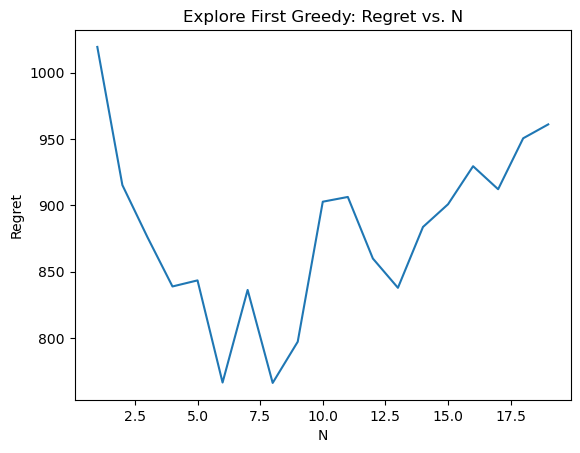

In [448]:
explore_mean = np.mean(explore_perf_data,axis=0)
plt.plot(N_range, explore_mean)
plt.title("Explore First Greedy: Regret vs. N")
plt.xlabel("N")
plt.ylabel("Regret")

## Epsilon Graphing

Text(0, 0.5, 'Regret')

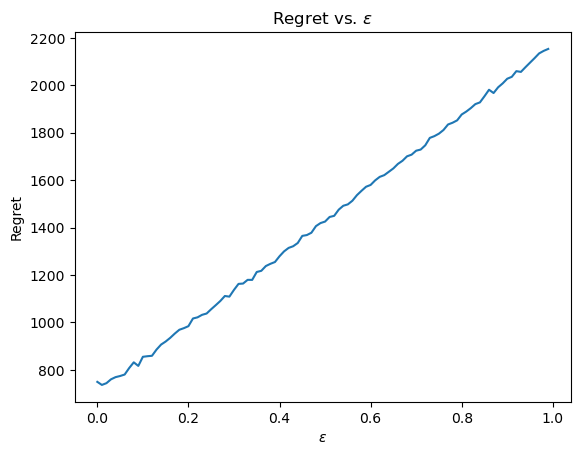

In [441]:
epsilon_mean = np.mean(epsilon_perf_data,axis=0)
plt.plot(epsilon_range, epsilon_mean)
plt.title("Epsilon: Regret vs. $\epsilon$")
plt.xlabel("$\epsilon$")
plt.ylabel("Regret")

## UCB Graphing

Text(0, 0.5, 'Regret')

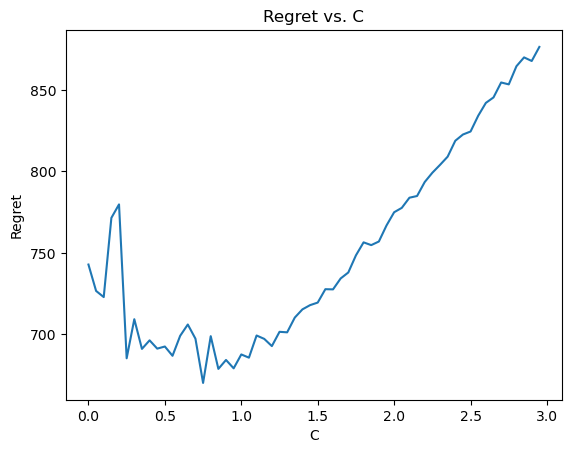

In [447]:
UCB_mean = np.mean(UCB_perf_data,axis=0)
plt.plot(exploration_range, UCB_mean)
plt.title("UCB: Regret vs. C")
plt.xlabel("C")
plt.ylabel("Regret")

## Gradient Graphing